In [1]:
from google.colab import files
uploaded = files.upload()


Saving retail_store_inventory.csv to retail_store_inventory.csv


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Optional for better visuals
sns.set(style='whitegrid', palette='muted', font_scale=1.1)


In [3]:
df = pd.read_csv("retail_store_inventory.csv")

# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

df.head()


,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Autumn
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer


In [4]:
# Dataset shape
print("Shape:", df.shape)

# Data types and non-null values
print(df.info())

# Descriptive stats
print(df.describe())


Shape: (73100, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                73100 non-null  datetime64[ns]
 1   Store ID            73100 non-null  object        
 2   Product ID          73100 non-null  object        
 3   Category            73100 non-null  object        
 4   Region              73100 non-null  object        
 5   Inventory Level     73100 non-null  int64         
 6   Units Sold          73100 non-null  int64         
 7   Units Ordered       73100 non-null  int64         
 8   Demand Forecast     73100 non-null  float64       
 9   Price               73100 non-null  float64       
 10  Discount            73100 non-null  int64         
 11  Weather Condition   73100 non-null  object        
 12  Holiday/Promotion   73100 non-null  int64         
 13  Competitor Pricing  73100 n

In [5]:
# Nulls
print("Missing Values:\n", df.isnull().sum())

# Duplicates
print("Duplicate Rows:", df.duplicated().sum())


Missing Values:
 Date                  0
Store ID              0
Product ID            0
Category              0
Region                0
Inventory Level       0
Units Sold            0
Units Ordered         0
Demand Forecast       0
Price                 0
Discount              0
Weather Condition     0
Holiday/Promotion     0
Competitor Pricing    0
Seasonality           0
dtype: int64
Duplicate Rows: 0


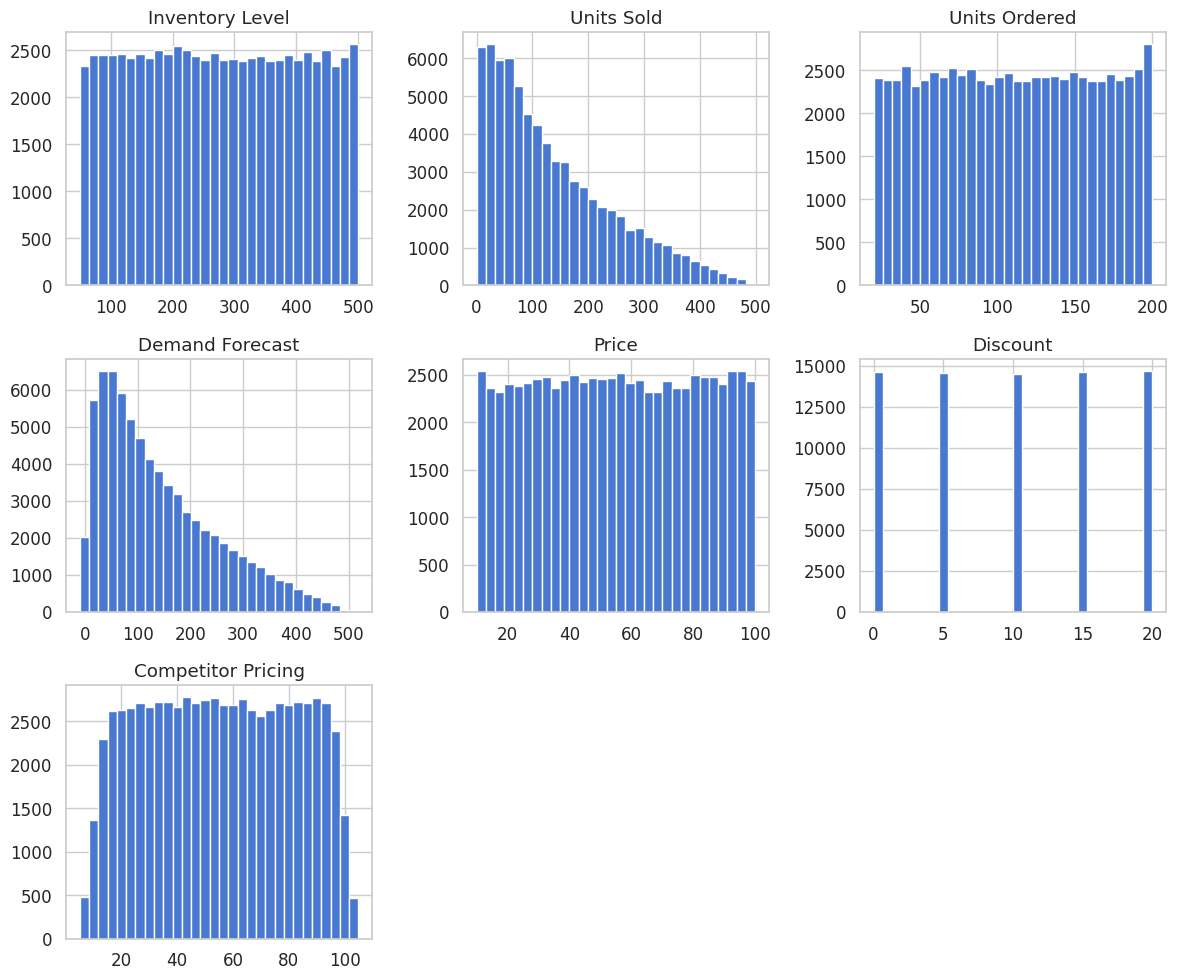

In [6]:
num_cols = ['Inventory Level', 'Units Sold', 'Units Ordered', 'Demand Forecast', 'Price', 'Discount', 'Competitor Pricing']

df[num_cols].hist(figsize=(12, 10), bins=30)
plt.tight_layout()
plt.show()



Category
Furniture      14699
Toys           14643
Clothing       14626
Groceries      14611
Electronics    14521
Name: count, dtype: int64
Region
East     18349
South    18297
North    18228
West     18226
Name: count, dtype: int64


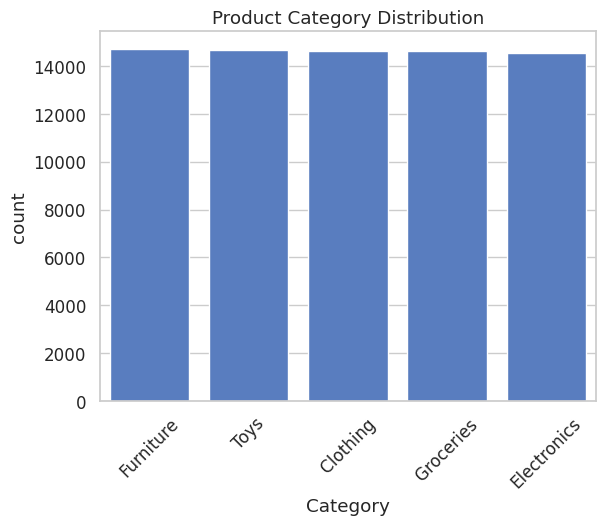

In [7]:
# Category counts
print(df['Category'].value_counts())

# Region counts
print(df['Region'].value_counts())

# Bar plot
sns.countplot(data=df, x='Category', order=df['Category'].value_counts().index)
plt.title("Product Category Distribution")
plt.xticks(rotation=45)
plt.show()


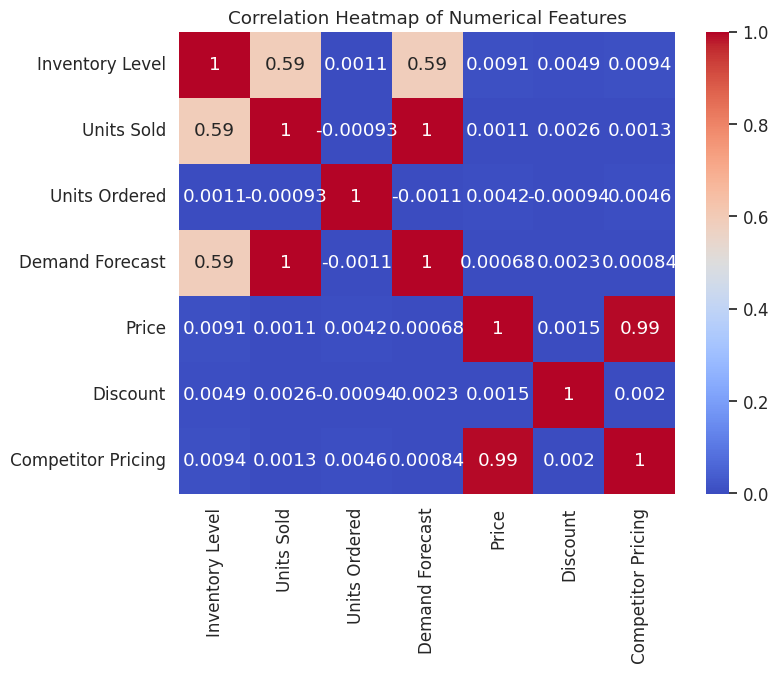

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Numerical Features")
plt.show()


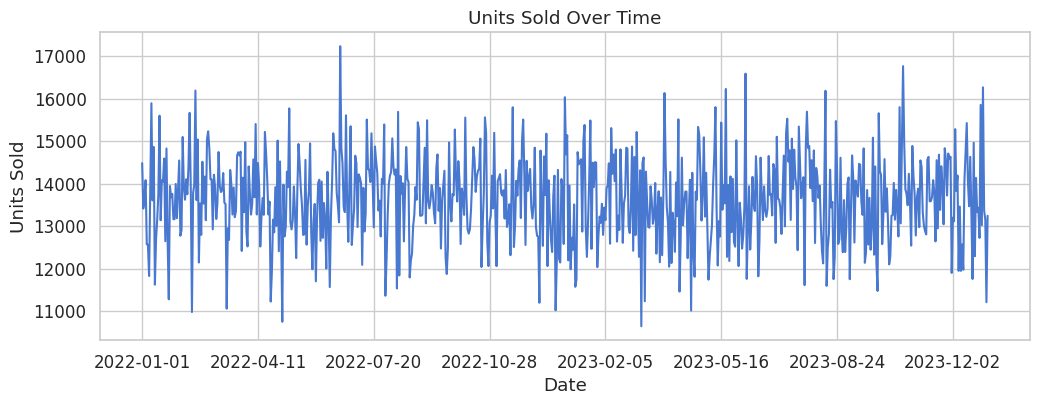

In [ ]:
# Group by date
daily_sales = df.groupby('Date')['Units Sold'].sum()

# Plot
daily_sales.plot(figsize=(12, 4), title='Units Sold Over Time')
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.show()


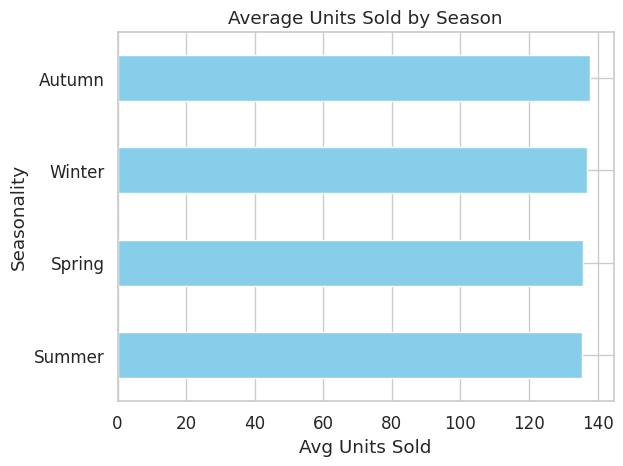

In [ ]:
seasonal_sales = df.groupby('Seasonality')['Units Sold'].mean().sort_values()

seasonal_sales.plot(kind='barh', color='skyblue')
plt.title("Average Units Sold by Season")
plt.xlabel("Avg Units Sold")
plt.show()


In [9]:
import pandas as pd
import sqlite3

# Load CSV into DataFrame
df = pd.read_csv('retail_store_inventory.csv')

# Clean column names
df.columns = df.columns.str.strip().str.replace(' ', '_').str.replace('/', '_').str.replace('-', '_')

# Create a SQLite connection
conn = sqlite3.connect(":memory:")

# Load DataFrame into SQL
df.to_sql("retail", conn, index=False, if_exists='replace')

query = """
SELECT
    Category,
    ROUND(SUM(Price * Units_Sold), 2) AS Total_Revenue,
    ROUND(SUM((Price - Competitor_Pricing) * (1 - Discount/100.0) * Units_Sold), 2) AS Total_Profit,
    ROUND((SUM((Price - Competitor_Pricing) * (1 - Discount/100.0) * Units_Sold) * 100.0) /
          NULLIF(SUM(Price * Units_Sold), 0), 2) AS Profit_Margin_Percent
FROM retail
GROUP BY Category
ORDER BY Profit_Margin_Percent ASC
"""

result_df = pd.read_sql_query(query, conn)
result_df

,Category,Total_Revenue,Total_Profit,Profit_Margin_Percent
0,Clothing,1.096510e+08,-64983.97,-0.06
1,Groceries,1.109845e+08,-64304.44,-0.06
2,Furniture,1.115118e+08,-48929.92,-0.04
3,Electronics,1.084391e+08,-13075.71,-0.01
4,Toys,1.096424e+08,67063.91,0.06


In [10]:
# Calculate profit per unit
df['Profit_per_unit'] = (df['Price'] - df['Competitor_Pricing']) * (1 - df['Discount'] / 100)

# Total profit
df['Total_Profit'] = df['Units_Sold'] * df['Profit_per_unit']

# Inventory Days = Inventory Level / Avg. daily sales (assumed 30-day month)
df['Inventory_Days'] = df['Inventory_Level'] / df['Units_Sold'].replace(0, 1)

In [11]:
correlation = df['Inventory_Days'].corr(df['Total_Profit'])
print(f"Correlation (Inventory Days vs Total Profit): {correlation:.3f}")


Correlation (Inventory Days vs Total Profit): 0.001


In [12]:
# Slow Movers
slow_movers = df[(df['Inventory_Days'] > df['Inventory_Days'].quantile(0.75)) &
                 (df['Total_Profit'] < 0)]

# Overstocked Items
overstocked = df[(df['Inventory_Level'] > df['Inventory_Level'].quantile(0.75)) &
                 (df['Units_Sold'] < df['Units_Sold'].quantile(0.25))]

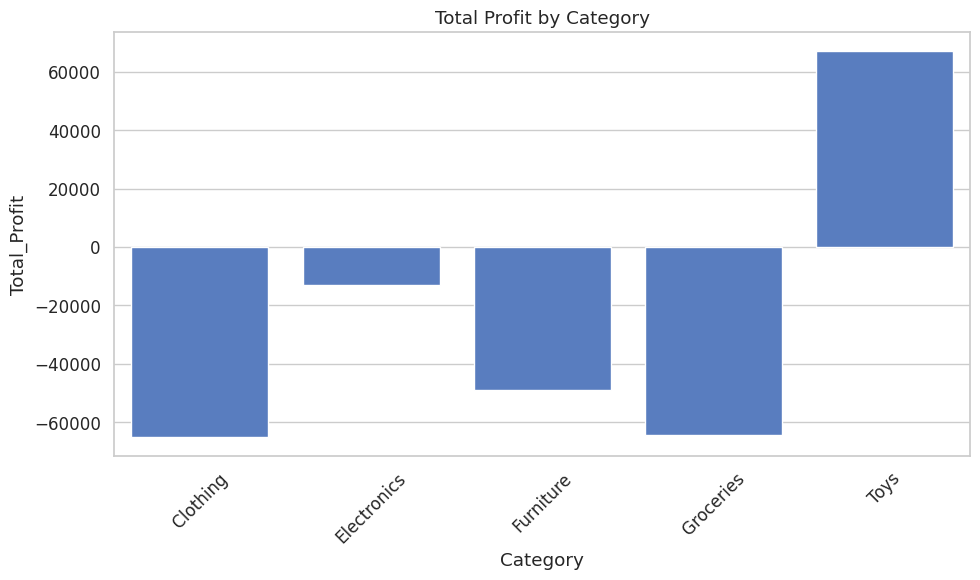

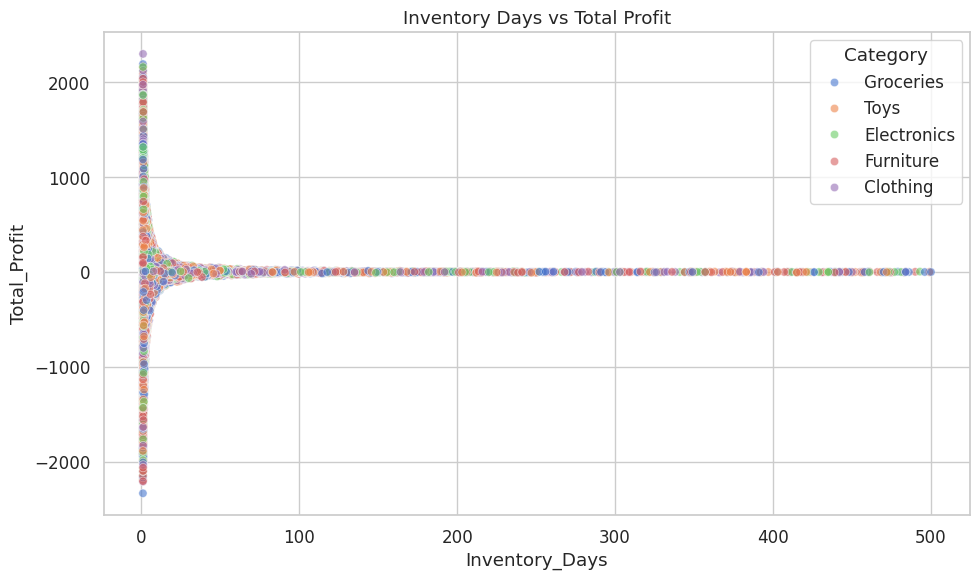

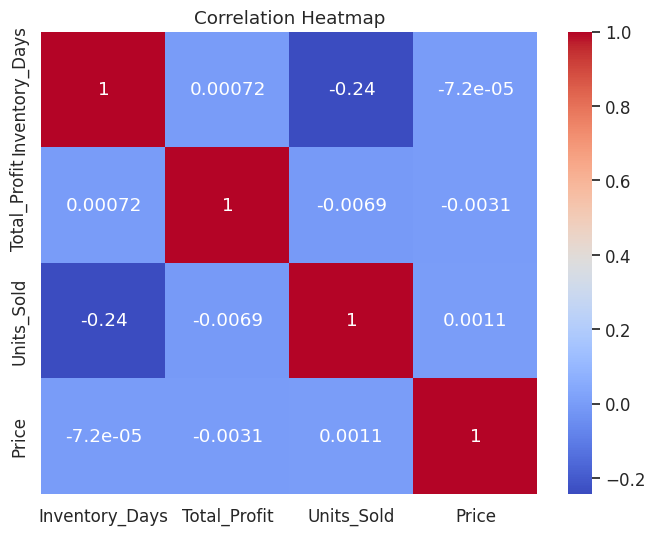

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Profit by Category
plt.figure(figsize=(10, 6))
cat_profit = df.groupby('Category')['Total_Profit'].sum().reset_index()
sns.barplot(data=cat_profit, x='Category', y='Total_Profit')
plt.title("Total Profit by Category")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Inventory Days vs Profit
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Inventory_Days', y='Total_Profit', hue='Category', alpha=0.6)
plt.title("Inventory Days vs Total Profit")
plt.tight_layout()
plt.show()

# Correlation Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df[['Inventory_Days', 'Total_Profit', 'Units_Sold', 'Price']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()
